# Music Style Transfer through LSTM

Here we are attempting to see whether we can transfer the style of the music by changing the notes themselves. Here, our definition of style transfer has changed. We are interested in seeing whether a network can generate music by being "inspired" from another music.

To do this, we will first train a CNN that classifies music well. Then, we will use the actiavtions from one of the layers as a feature extractor and extract features from music. 

Next step is to use the features we extracted to generate the music back. This is done by conditioning a (possibly bidirectional) LSTM using the feature vector, and then train it to generate the music that was used to extract the feature vector. We will train 2 such generators.

Last step is to see whether the generators works as a translator. We will take one music from one class and extract the features. And then feed the feature into the other class to generate music. We will see if the network picks up the styles and whether the network can be "inspired" by the music

In [1]:
import os
import mido
import keras
import numpy as np
import sklearn.model_selection as ms
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
set_session(session)

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

## Loading data

Here we will load the data that was already preprocessed. We will do some final stitching to make it usable for our algorithms. One of the thing we realized is that the files are different sizes. So in order for CNN to work they must be the same size. So what we will do is just simply pad them with 0s so it will not affect training.

In [4]:
classical_matrices = np.load('matricies/classical_matrices.npy')
jazz_matrices = np.load('matricies/jazz_matrices.npy')
classical_infos = np.load('matricies/classical_infos.npy')
jazz_infos = np.load('matricies/jazz_infos.npy')

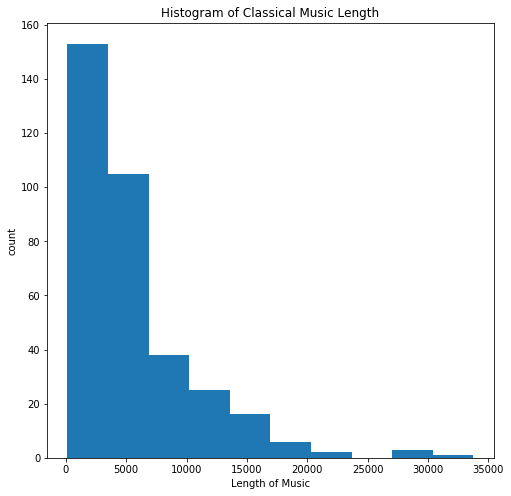

In [7]:
plt.figure(figsize=(8, 8))
plt.hist([x.shape[0] for x in classical_matrices])
plt.savefig('plots/classical_hist.png')
plt.title('Histogram of Classical Music Length')
plt.xlabel('Length of Music')
plt.ylabel('Count')
plt.show()

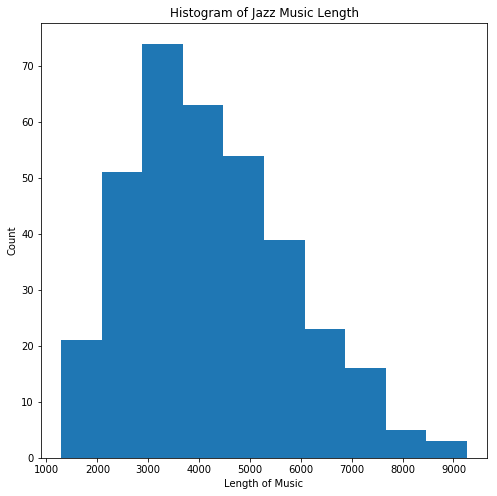

In [8]:
plt.figure(figsize=(8, 8))
plt.hist([x.shape[0] for x in jazz_matrices])
plt.savefig('plots/jazz_hist.png')
plt.title('Histogram of Jazz Music Length')
plt.xlabel('Length of Music')
plt.ylabel('Count')
plt.show()

In [9]:
## Here we pad every array to be of size 5000
T = 5000
for i in range(len(classical_matrices)):
    m = classical_matrices[i]
    if m.shape[0] > T:
        classical_matrices[i] = m[:T, :, :]
    else:
        classical_matrices[i] = np.pad(m, ((0, T - m.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=(0,))

In [10]:
for i in range(len(jazz_matrices)):
    m = jazz_matrices[i]
    if m.shape[0] > T:
        jazz_matrices[i] = m[:T, :, :]
    else:
        jazz_matrices[i] = np.pad(m, ((0, T - m.shape[0]), (0, 0), (0, 0)), 'constant', constant_values=(0,))

In [11]:
X1 = np.stack(classical_matrices)
X2 = np.stack(jazz_matrices)
X = np.concatenate((X1, X2), axis=0)
Y1 = np.ones(len(classical_matrices))
Y2 = np.zeros(len(jazz_matrices))
Y = np.concatenate((Y1, Y2))
Y = Y.reshape((-1, 1))

In [12]:
print(X.shape)
print(Y.shape)

(698, 5000, 130, 2)
(698, 1)


Now we need to stack the last 2 layers since we will look at them at the same time anyways

In [13]:
X3 = np.concatenate((X[:,:,:,0], X[:,:,:,1]), axis=-1)
print(X3.shape)

(698, 5000, 260)


In [14]:
np.save('matricies/newX.npy', X3)
np.save('matricies/newY.npy', Y)

In [4]:
X = np.load('matricies/newX.npy')
Y = np.load('matricies/newY.npy')

In [5]:
print(X.shape)

(698, 5000, 260)


In [6]:
X_train, X_test, Y_train, Y_test = ms.train_test_split(X, Y, test_size=0.2, random_state=123)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(558, 5000, 260) (140, 5000, 260) (558, 1) (140, 1)


## CNN encoding

In this section we first try to train a CNN that classifies music well. Here we will use a simple structure of

1. Conv
2. Dense
...


In [7]:
def model1(input_shape):
    X_input = keras.layers.Input(input_shape)
    X = X_input
    X = keras.layers.Conv1D(filters=10, kernel_size=50, padding='same', name='Conv0',
                            dilation_rate=8,
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.AveragePooling1D(20)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn0')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    
#     X = keras.layers.Reshape((250, -1))(X)
    X = keras.layers.Conv1D(filters=40, kernel_size=20, padding='valid', name='Conv1',
                            dilation_rate=4,
                            kernel_initializer=keras.initializers.glorot_normal(seed=None),
                            bias_initializer=keras.initializers.glorot_normal(seed=None),
                            data_format="channels_last")(X)
    X = keras.layers.AveragePooling1D(20)(X)
    X = keras.layers.BatchNormalization(axis = 2, name = 'bn1')(X)
    X = keras.layers.Activation('relu')(X)
    print(X.shape)
    X = keras.layers.Flatten()(X)
#     X = keras.layers.Dense(100, activation='sigmoid')(X)
#     X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(50, activation='sigmoid')(X)
    X = keras.layers.Dropout(0.5)(X)    
    X = keras.layers.Dense(10, activation='sigmoid')(X)
    X = keras.layers.Dense(1, activation='sigmoid')(X)
    model = keras.models.Model(inputs=X_input, outputs=X, name='basic')
    return model

In [8]:
m = model1(X.shape[1:])
m.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

(?, 250, 10)
(?, 8, 40)


In [9]:
print(m.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 5000, 260)         0         
_________________________________________________________________
Conv0 (Conv1D)               (None, 5000, 10)          130010    
_________________________________________________________________
average_pooling1d_1 (Average (None, 250, 10)           0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 250, 10)           40        
_________________________________________________________________
activation_1 (Activation)    (None, 250, 10)           0         
_________________________________________________________________
Conv1 (Conv1D)               (None, 174, 40)           8040      
_________________________________________________________________
average_pooling1d_2 (Average (None, 8, 40)             0         
__________

In [12]:
m.fit(X_train, Y_train, epochs=4)

Epoch 1/4
558/558 [==============================] - 35s 62ms/step - loss: 0.4735 - binary_accuracy: 0.8548
Epoch 2/4
558/558 [==============================] - 34s 62ms/step - loss: 0.3852 - binary_accuracy: 0.9409
Epoch 3/4
558/558 [==============================] - 35s 62ms/step - loss: 0.3243 - binary_accuracy: 0.9642
Epoch 4/4
558/558 [==============================] - 34s 62ms/step - loss: 0.2851 - binary_accuracy: 0.9695


In [13]:
preds = m.evaluate(X_test, Y_test)
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

140/140 [==============================] - 5s 35ms/step
Loss = 0.3178471607821328
Test Accuracy = 0.9428571445601327


In [19]:
m.save('cnn.h5')

In [ ]:
m = keras.model.load('cnn.h5')

## LSTM 

Here we will train 2 (bidirectional) LSTMs. One for generating classical music and one for generating jazz music. The way we condition the LSTMs is to have a Dense layer that transforms our feature vectors into the shape of the cell state of the LSTM, and then we will use this cell state as the initial cell state of the LSTM, and train it to generate the original MIDI matrix. 

The input to the model is a feature vector. It will then have a dense layer that transforms it into the cell state shape. Then for every time stamp it will generate some music, and the output should be a music.

First we need to construct the new X and Ys. The X will be the same but with the last layer stacked on top of each other insead. Y will be the same as X but all values shifted left by 1 timestamp

In [14]:
gen_T = 30
m_examples = 340
X2_classical = X[(Y==1).ravel(), :gen_T, :][:m_examples,:,:]
X2_jazz = X[(Y==0).ravel(), :gen_T, :][:m_examples,:,:]
Y2_classical = np.zeros(X2_classical.shape, dtype=np.int32)
Y2_classical[:-1,:,:] = X2_classical[1:,:,:]
Y2_jazz = np.zeros(X2_jazz.shape, dtype=np.int32)
Y2_jazz[:-1,:,:] = X2_jazz[1:,:,:]

Now we need to extract the features we will use to create the beautiful piece of music. 

In [15]:
[m.layers[i] for i in [9, 10]]

In [16]:
def extract_all_features(X, model, layer_nums, batch_num):
    """Extract all the features by taking out the activation output of the layers specified in layer_nums
    
        X : the data that we are trying to extract features from
        model: the model that we are using to extract the features
        layer_nums: the layer number that we want to use as feature extractors
    """
    outputs = [model.layers[layer].output for layer in layer_nums]
    f = keras.backend.function([model.input, keras.backend.learning_phase()], outputs)
    ## split up into smaller chunks
    layer_outs = []
    m = X.shape[0]
    for i in range(batch_num):
        print((m // batch_num * i, m // batch_num * (i+1)))
        layer_outs += [f([X[(m // batch_num * i):(m // batch_num * (i+1)), :, :], 0.])]
    result = []
    for i in range(len(layer_nums)):
        layer_outs2 = []
        for batch in range(batch_num):
            activations = layer_outs[batch][i]
            activations = activations.reshape(activations.shape[0], -1)
            layer_outs2 += [activations]
        result += [np.vstack(np.array(layer_outs2))]
    return result

In [17]:
classical_features = extract_all_features(X[(Y == 1).ravel(), :, :], m, [9, 10], 10)

(0, 34)
(34, 68)
(68, 102)
(102, 136)
(136, 170)
(170, 204)
(204, 238)
(238, 272)
(272, 306)
(306, 340)


In [18]:
jazz_features = extract_all_features(X[(Y == 0).ravel(), :, :], m, [9, 10], 10)

(0, 34)
(34, 68)
(68, 102)
(102, 136)
(136, 170)
(170, 204)
(204, 238)
(238, 272)
(272, 306)
(306, 340)


In [ ]:
jazz_features[1].shape

The following code is inspired and borrowed from Coursera Sequence Model Module/Improvise a Jazz Solo with an LSTM Network - v3 programming assignment

In [20]:
n_a = 64
n_values = 260
LSTM_cell = keras.layers.LSTM(n_a, return_state = True)
densor = keras.layers.Dense(n_values, activation='softmax')

In [21]:
def lstm(feature_shape, Tx, n_channel):
    feature_input = keras.layers.Input(feature_shape, name='feature_inp')
    music_input = keras.layers.Input((Tx, n_channel), name='X')
    a0 = keras.layers.Input((n_a,), name='a0')
    
#     feature = keras.layers.Flatten()(feature_input)
    c0 = keras.layers.Dense(n_a)(feature_input)
    X = music_input
    a = a0
    c = c0
    outputs = []
    for t in range(Tx):
        if t % 200 == 0:
            print(t)
        x = keras.layers.Lambda(lambda x: X[:, t, :])(X)
        x = keras.layers.Reshape((1, n_channel))(x)
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        out = densor(a)
        outputs += [out]
    return keras.models.Model(inputs=[feature_input, music_input, a0], outputs=outputs)
    
    

In [26]:
lstm_model = lstm((classical_features[1].shape[1], ), gen_T, X.shape[2])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

0


In [25]:
a0 = np.zeros((m_examples, n_a))
lstm_model.fit([classical_features[1], X2_classical, a0], list(Y2_classical.transpose((1, 0, 2))), epochs=100)

Epoch 1/100
340/340 [==============================] - 1s 3ms/step - loss: 444.6669 - dense_4_loss: 4.0145 - dense_4_acc: 0.0147 - dense_4_acc_1: 0.0029 - dense_4_acc_2: 0.0088 - dense_4_acc_3: 0.0029 - dense_4_acc_4: 0.0059 - dense_4_acc_5: 0.0000e+00 - dense_4_acc_6: 0.0000e+00 - dense_4_acc_7: 0.0000e+00 - dense_4_acc_8: 0.0059 - dense_4_acc_9: 0.0000e+00 - dense_4_acc_10: 0.0000e+00 - dense_4_acc_11: 0.0029 - dense_4_acc_12: 0.0000e+00 - dense_4_acc_13: 0.0000e+00 - dense_4_acc_14: 0.0000e+00 - dense_4_acc_15: 0.0000e+00 - dense_4_acc_16: 0.0618 - dense_4_acc_17: 0.0000e+00 - dense_4_acc_18: 0.0029 - dense_4_acc_19: 0.0088 - dense_4_acc_20: 0.0029 - dense_4_acc_21: 0.0029 - dense_4_acc_22: 0.0118 - dense_4_acc_23: 0.0029 - dense_4_acc_24: 0.0029 - dense_4_acc_25: 0.0059 - dense_4_acc_26: 0.0029 - dense_4_acc_27: 0.0029 - dense_4_acc_28: 0.0000e+00 - dense_4_acc_29: 0.0029                                          
Epoch 2/100
340/340 [==============================] - 1s 3ms/step - 

340/340 [==============================] - 1s 3ms/step - loss: 443.9089 - dense_4_loss: 3.9890 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0059 - dense_4_acc_3: 0.0206 - dense_4_acc_4: 0.0147 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0294 - dense_4_acc_7: 0.0235 - dense_4_acc_8: 0.0029 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0147 - dense_4_acc_11: 0.0118 - dense_4_acc_12: 0.0265 - dense_4_acc_13: 0.0176 - dense_4_acc_14: 0.0088 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1000 - dense_4_acc_17: 0.0353 - dense_4_acc_18: 0.0176 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0206 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0265 - dense_4_acc_23: 0.0176 - dense_4_acc_24: 0.0265 - dense_4_acc_25: 0.0382 - dense_4_acc_26: 0.0088 - dense_4_acc_27: 0.0176 - dense_4_acc_28: 0.0176 - dense_4_acc_29: 0.0324                          
Epoch 11/100
340/340 [==============================] - 1s 3ms/step - loss: 443.8600 - dense_4_loss: 3.9895 - dense_4_acc: 0.1206 - dense_4_a

340/340 [==============================] - 1s 3ms/step - loss: 443.7214 - dense_4_loss: 3.9914 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0059 - dense_4_acc_3: 0.0206 - dense_4_acc_4: 0.0147 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0294 - dense_4_acc_7: 0.0235 - dense_4_acc_8: 0.0029 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0147 - dense_4_acc_11: 0.0059 - dense_4_acc_12: 0.0235 - dense_4_acc_13: 0.0147 - dense_4_acc_14: 0.0059 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1147 - dense_4_acc_17: 0.0353 - dense_4_acc_18: 0.0118 - dense_4_acc_19: 0.0235 - dense_4_acc_20: 0.0147 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0206 - dense_4_acc_23: 0.0147 - dense_4_acc_24: 0.0206 - dense_4_acc_25: 0.0265 - dense_4_acc_26: 0.0059 - dense_4_acc_27: 0.0176 - dense_4_acc_28: 0.0176 - dense_4_acc_29: 0.0265                                                                
Epoch 20/100
340/340 [==============================] - 1s 4ms/step - loss: 443.7171 - dense_4_loss: 3.

340/340 [==============================] - 1s 3ms/step - loss: 443.7008 - dense_4_loss: 3.9916 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0059 - dense_4_acc_3: 0.0206 - dense_4_acc_4: 0.0147 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0235 - dense_4_acc_7: 0.0206 - dense_4_acc_8: 0.0029 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0088 - dense_4_acc_11: 0.0059 - dense_4_acc_12: 0.0206 - dense_4_acc_13: 0.0147 - dense_4_acc_14: 0.0059 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1206 - dense_4_acc_17: 0.0353 - dense_4_acc_18: 0.0118 - dense_4_acc_19: 0.0235 - dense_4_acc_20: 0.0147 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0206 - dense_4_acc_23: 0.0147 - dense_4_acc_24: 0.0265 - dense_4_acc_25: 0.0206 - dense_4_acc_26: 0.0059 - dense_4_acc_27: 0.0176 - dense_4_acc_28: 0.0206 - dense_4_acc_29: 0.0265                          
Epoch 29/100
340/340 [==============================] - 1s 3ms/step - loss: 443.6922 - dense_4_loss: 3.9913 - dense_4_acc: 0.1206 - dense_4_a

340/340 [==============================] - 1s 4ms/step - loss: 443.6531 - dense_4_loss: 3.9882 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0059 - dense_4_acc_3: 0.0206 - dense_4_acc_4: 0.0147 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0294 - dense_4_acc_7: 0.0235 - dense_4_acc_8: 0.0029 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0147 - dense_4_acc_11: 0.0059 - dense_4_acc_12: 0.0206 - dense_4_acc_13: 0.0147 - dense_4_acc_14: 0.0088 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1206 - dense_4_acc_17: 0.0353 - dense_4_acc_18: 0.0118 - dense_4_acc_19: 0.0235 - dense_4_acc_20: 0.0147 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0235 - dense_4_acc_23: 0.0147 - dense_4_acc_24: 0.0294 - dense_4_acc_25: 0.0324 - dense_4_acc_26: 0.0147 - dense_4_acc_27: 0.0206 - dense_4_acc_28: 0.0235 - dense_4_acc_29: 0.0294                              
Epoch 38/100
340/340 [==============================] - 1s 3ms/step - loss: 443.6510 - dense_4_loss: 3.9878 - dense_4_acc: 0.1206 - dense

340/340 [==============================] - 1s 4ms/step - loss: 443.6053 - dense_4_loss: 3.9873 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0088 - dense_4_acc_3: 0.0235 - dense_4_acc_4: 0.0206 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0324 - dense_4_acc_7: 0.0235 - dense_4_acc_8: 0.0059 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0235 - dense_4_acc_11: 0.0088 - dense_4_acc_12: 0.0265 - dense_4_acc_13: 0.0176 - dense_4_acc_14: 0.0088 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1382 - dense_4_acc_17: 0.0382 - dense_4_acc_18: 0.0206 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0147 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0324 - dense_4_acc_23: 0.0206 - dense_4_acc_24: 0.0294 - dense_4_acc_25: 0.0353 - dense_4_acc_26: 0.0235 - dense_4_acc_27: 0.0176 - dense_4_acc_28: 0.0265 - dense_4_acc_29: 0.0294                 - ETA: 0s - loss: 532.8395 - dense_4_loss: 4.0255 - dense_4_acc: 0.1367 - dense_4_acc_1: 0.0352 - dense_4_acc_2: 0.0078 - dense_4_acc_3: 0.0312 - dense

340/340 [==============================] - 1s 4ms/step - loss: 443.5559 - dense_4_loss: 3.9859 - dense_4_acc: 0.1206 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0088 - dense_4_acc_3: 0.0235 - dense_4_acc_4: 0.0206 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0382 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0147 - dense_4_acc_9: 0.0176 - dense_4_acc_10: 0.0265 - dense_4_acc_11: 0.0088 - dense_4_acc_12: 0.0265 - dense_4_acc_13: 0.0176 - dense_4_acc_14: 0.0088 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1353 - dense_4_acc_17: 0.0412 - dense_4_acc_18: 0.0206 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0176 - dense_4_acc_21: 0.0118 - dense_4_acc_22: 0.0353 - dense_4_acc_23: 0.0235 - dense_4_acc_24: 0.0324 - dense_4_acc_25: 0.0353 - dense_4_acc_26: 0.0265 - dense_4_acc_27: 0.0206 - dense_4_acc_28: 0.0265 - dense_4_acc_29: 0.0294                                                          
Epoch 55/100
340/340 [==============================] - 1s 4ms/step - loss: 443.5533 - dense_4_loss: 3.9859 -

340/340 [==============================] - 1s 4ms/step - loss: 443.4962 - dense_4_loss: 3.9847 - dense_4_acc: 0.1235 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0118 - dense_4_acc_3: 0.0235 - dense_4_acc_4: 0.0235 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0382 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0206 - dense_4_acc_9: 0.0206 - dense_4_acc_10: 0.0265 - dense_4_acc_11: 0.0118 - dense_4_acc_12: 0.0441 - dense_4_acc_13: 0.0176 - dense_4_acc_14: 0.0088 - dense_4_acc_15: 0.0176 - dense_4_acc_16: 0.1471 - dense_4_acc_17: 0.0412 - dense_4_acc_18: 0.0265 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0265 - dense_4_acc_21: 0.0147 - dense_4_acc_22: 0.0500 - dense_4_acc_23: 0.0294 - dense_4_acc_24: 0.0471 - dense_4_acc_25: 0.0471 - dense_4_acc_26: 0.0294 - dense_4_acc_27: 0.0235 - dense_4_acc_28: 0.0324 - dense_4_acc_29: 0.0324
Epoch 64/100
340/340 [==============================] - 1s 4ms/step - loss: 443.5066 - dense_4_loss: 3.9850 - dense_4_acc: 0.1235 - dense_4_acc_1: 0.0382 - dense_4_acc

340/340 [==============================] - 1s 4ms/step - loss: 443.4404 - dense_4_loss: 3.9846 - dense_4_acc: 0.1235 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0118 - dense_4_acc_3: 0.0294 - dense_4_acc_4: 0.0265 - dense_4_acc_5: 0.0147 - dense_4_acc_6: 0.0412 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0265 - dense_4_acc_9: 0.0206 - dense_4_acc_10: 0.0265 - dense_4_acc_11: 0.0059 - dense_4_acc_12: 0.0412 - dense_4_acc_13: 0.0206 - dense_4_acc_14: 0.0147 - dense_4_acc_15: 0.0206 - dense_4_acc_16: 0.1559 - dense_4_acc_17: 0.0382 - dense_4_acc_18: 0.0294 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0324 - dense_4_acc_21: 0.0147 - dense_4_acc_22: 0.0471 - dense_4_acc_23: 0.0382 - dense_4_acc_24: 0.0471 - dense_4_acc_25: 0.0559 - dense_4_acc_26: 0.0324 - dense_4_acc_27: 0.0265 - dense_4_acc_28: 0.0441 - dense_4_acc_29: 0.0324                                                  
Epoch 73/100
340/340 [==============================] - 1s 3ms/step - loss: 443.4294 - dense_4_loss: 3.9843 - dense_4

340/340 [==============================] - 1s 4ms/step - loss: 443.3871 - dense_4_loss: 3.9827 - dense_4_acc: 0.1294 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0147 - dense_4_acc_3: 0.0324 - dense_4_acc_4: 0.0265 - dense_4_acc_5: 0.0206 - dense_4_acc_6: 0.0471 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0265 - dense_4_acc_9: 0.0265 - dense_4_acc_10: 0.0294 - dense_4_acc_11: 0.0147 - dense_4_acc_12: 0.0441 - dense_4_acc_13: 0.0235 - dense_4_acc_14: 0.0147 - dense_4_acc_15: 0.0235 - dense_4_acc_16: 0.1618 - dense_4_acc_17: 0.0441 - dense_4_acc_18: 0.0324 - dense_4_acc_19: 0.0265 - dense_4_acc_20: 0.0353 - dense_4_acc_21: 0.0147 - dense_4_acc_22: 0.0559 - dense_4_acc_23: 0.0441 - dense_4_acc_24: 0.0588 - dense_4_acc_25: 0.0588 - dense_4_acc_26: 0.0353 - dense_4_acc_27: 0.0265 - dense_4_acc_28: 0.0500 - dense_4_acc_29: 0.0382                        
Epoch 82/100
340/340 [==============================] - 1s 4ms/step - loss: 443.3834 - dense_4_loss: 3.9827 - dense_4_acc: 0.1294 - dense_4_acc

340/340 [==============================] - 1s 4ms/step - loss: 443.3457 - dense_4_loss: 3.9808 - dense_4_acc: 0.1324 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0147 - dense_4_acc_3: 0.0324 - dense_4_acc_4: 0.0265 - dense_4_acc_5: 0.0206 - dense_4_acc_6: 0.0500 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0294 - dense_4_acc_9: 0.0294 - dense_4_acc_10: 0.0294 - dense_4_acc_11: 0.0088 - dense_4_acc_12: 0.0471 - dense_4_acc_13: 0.0206 - dense_4_acc_14: 0.0176 - dense_4_acc_15: 0.0235 - dense_4_acc_16: 0.1676 - dense_4_acc_17: 0.0441 - dense_4_acc_18: 0.0353 - dense_4_acc_19: 0.0353 - dense_4_acc_20: 0.0382 - dense_4_acc_21: 0.0147 - dense_4_acc_22: 0.0559 - dense_4_acc_23: 0.0441 - dense_4_acc_24: 0.0647 - dense_4_acc_25: 0.0588 - dense_4_acc_26: 0.0353 - dense_4_acc_27: 0.0265 - dense_4_acc_28: 0.0500 - dense_4_acc_29: 0.0412                                                  
Epoch 90/100
340/340 [==============================] - 1s 4ms/step - loss: 443.3486 - dense_4_loss: 3.9810 - dense_4

340/340 [==============================] - 1s 4ms/step - loss: 443.3020 - dense_4_loss: 3.9782 - dense_4_acc: 0.1324 - dense_4_acc_1: 0.0382 - dense_4_acc_2: 0.0147 - dense_4_acc_3: 0.0324 - dense_4_acc_4: 0.0324 - dense_4_acc_5: 0.0235 - dense_4_acc_6: 0.0529 - dense_4_acc_7: 0.0265 - dense_4_acc_8: 0.0324 - dense_4_acc_9: 0.0324 - dense_4_acc_10: 0.0294 - dense_4_acc_11: 0.0147 - dense_4_acc_12: 0.0529 - dense_4_acc_13: 0.0235 - dense_4_acc_14: 0.0176 - dense_4_acc_15: 0.0265 - dense_4_acc_16: 0.1735 - dense_4_acc_17: 0.0441 - dense_4_acc_18: 0.0353 - dense_4_acc_19: 0.0353 - dense_4_acc_20: 0.0471 - dense_4_acc_21: 0.0176 - dense_4_acc_22: 0.0559 - dense_4_acc_23: 0.0441 - dense_4_acc_24: 0.0647 - dense_4_acc_25: 0.0618 - dense_4_acc_26: 0.0353 - dense_4_acc_27: 0.0294 - dense_4_acc_28: 0.0500 - dense_4_acc_29: 0.0471              
Epoch 99/100
340/340 [==============================] - 1s 4ms/step - loss: 443.2984 - dense_4_loss: 3.9781 - dense_4_acc: 0.1324 - dense_4_acc_1: 0.0382